In [1]:
import sys
sys.path.append('/home/linxuangao')  # 确保父目录在 Python 路径中

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch

from GPNSF.model import *
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 指定GPU设备索引
gpu_id = 2  # 使用第4张GPU（索引从0开始）
torch.cuda.set_device(gpu_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Current GPU: {torch.cuda.current_device()}')

Using device: cuda
Current GPU: 2


In [4]:
data_dir = '/home/linxuangao/data_gpnsf/Dataset13_Simulation1'
adata1 = sc.read_h5ad(f'{data_dir}/adata_RNA.h5ad')
X_1 = adata1.layers['counts']
S = adata1.obsm['spatial']
spfac = adata1.obsm['spfac']
nsfac = adata1.obsm['nsfac']
spload_1 = adata1.varm['spload']
p = X_1.shape[1]
adata2 = sc.read_h5ad(f'{data_dir}/adata_ADT.h5ad')
X_2 = adata2.layers['counts']
spload_2 = adata2.varm['spload']
q = X_2.shape[1]

In [5]:
S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([1296, 2]) X1: torch.Size([1296, 1000]) X2: torch.Size([1296, 100]) device= cuda


In [6]:
K = 4
M = 40

In [7]:
model = GPNSFModel(
    S=S_t, p=p, q=q, K=K, M=M, 
    eta=10.0, 
    num_mc_samples=3, 
    likelihood_x2='nb', 
    omega_type='chol', 
    kernel_type='matern32'
).to(device)

# 训练模型
model = train_model(
    model=model,
    X1_t=X1_t,
    X2_t=X2_t,
    num_steps=1000,
    lr_schedule=None,
    print_every=250
)

  0%|          | 4/1000 [00:00<02:26,  6.81it/s]

[step 001] loss=2833278.250  ELBO=-2807190.750  KL=39.366  loglik1=-2375837.000  loglik2=-436689.812  lr=1.0e-02


 25%|██▌       | 254/1000 [00:10<00:29, 25.31it/s]

[step 250] loss=2012206.250  ELBO=-2010141.750  KL=121.870  loglik1=-1684013.750  loglik2=-325937.969  lr=1.0e-02


 50%|█████     | 505/1000 [00:19<00:18, 27.32it/s]

[step 500] loss=1953265.500  ELBO=-1953155.000  KL=208.550  loglik1=-1637071.000  loglik2=-313621.469  lr=1.0e-02


 76%|███████▌  | 756/1000 [00:28<00:08, 28.90it/s]

[step 750] loss=1942886.625  ELBO=-1942991.000  KL=238.959  loglik1=-1630427.750  loglik2=-310075.406  lr=1.0e-02


100%|██████████| 1000/1000 [00:37<00:00, 26.60it/s]

[step 1000] loss=1940847.250  ELBO=-1940850.250  KL=253.544  loglik1=-1628649.750  loglik2=-309412.375  lr=1.0e-02
Training finished.


In [8]:
add_latent_to_adata(adata1, model)

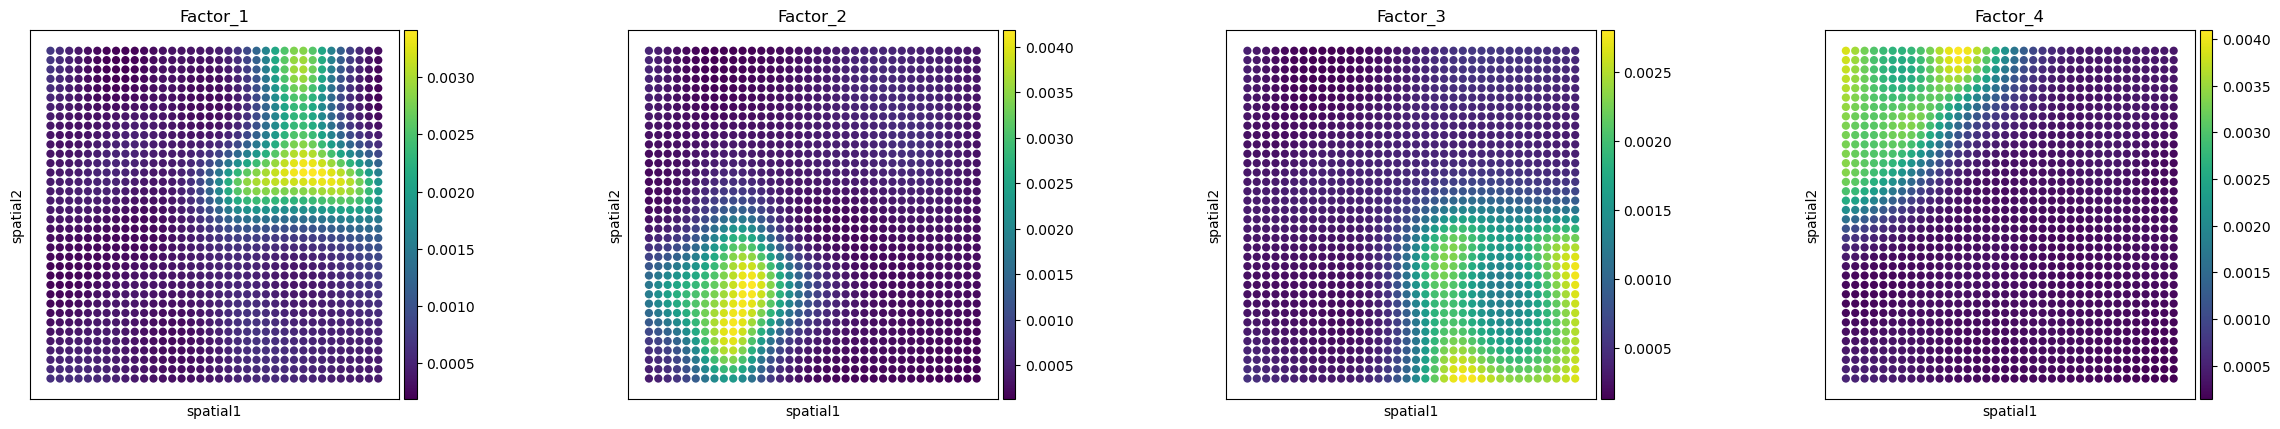

In [ ]:
fig = sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(K)],
    spot_size=0.1,
    show=True 
)
